In [ ]:
# Instala las bibliotecas necesarias
!pip install imblearn
!pip install catboost
!pip install optuna
!pip install --upgrade jupyter
!pip install --upgrade pip
!pip install xgboost lightgbm
!pip install -U imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 38.0 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 16.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 738.9/738.9 kB 78.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 110.7 MB/s eta 0:00:00
     ━━━━━━━━━

In [ ]:
# Importa las bibliotecas
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, 
                             roc_curve, roc_auc_score)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline
import optuna

In [ ]:
# Carga el conjunto de datos
path = "/work/stroke_dataset.csv"
df = pd.read_csv(path)

# Características y objetivo
X = df.drop('stroke', axis=1)
y = df['stroke']

In [ ]:
# Define características
columnas_categoricas = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
columnas_numericas = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']

In [ ]:
models = {
    "LOGISTIC REGRESSION":LogisticRegression(),
    "LIGHTGBM":LGBMClassifier(),
    "XGBOOST":XGBClassifier(),
    "GBC":GradientBoostingClassifier(),
    "AdaBC":AdaBoostClassifier,
    "CATBC":CatBoostClassifier
}

def plot_roc_curve(y_true, y_scores, model_name):
    """
    Dibuja la curva ROC para las etiquetas verdaderas y las puntuaciones predichas.
    """
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    auc = roc_auc_score(y_true, y_scores)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('Tasa de falsos positivos')
    plt.ylabel('Tasa de verdaderos positivos')
    plt.title(f'Curva ROC para {model_name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

In [ ]:
def evaluate_models(models, X, y):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Variables para almacenar los resultados del mejor modelo
    best_model = None
    best_metrics = None
    best_model_name = None  # Agrega esta línea para mantener el nombre del mejor modelo
    best_cm = None  # Matriz de confusión del mejor modelo
    aggregated_y_true = []  # Lista para almacenar etiquetas verdaderas agregadas
    aggregated_y_scores = []  # Lista para almacenar puntuaciones predichas agregadas

    def objective(trial):
        nonlocal best_model_name, best_cm, best_metrics
        model_name = trial.suggest_categorical("model", list(models.keys()))
        model = None

        if model_name == "LOGISTIC REGRESSION":
            C = trial.suggest_loguniform("C", 1e-5, 1e5)  # Hiperparámetro C
            penalty = trial.suggest_categorical("penalty", ["l1"])  # Hiperparámetro penalty
            solver = trial.suggest_categorical("solver", ["liblinear"])  # Hiperparámetro solver,  "lbfgs"
            max_iter = trial.suggest_int("max_iter", 100, 10000)  # Hiperparámetro max_iter
            model = LogisticRegression(C=C, penalty=penalty, solver=solver, max_iter=max_iter)
        elif model_name == "LIGHTGBM":
            learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
            n_estimators = trial.suggest_int("n_estimators", 50, 500)
            max_depth = trial.suggest_int("max_depth", 3, 15)
            min_child_weight = trial.suggest_float('min_child_weight', 1e-5, 1e2, log=True)
            subsample = trial.suggest_float('subsample', 0.5, 1.0)
            colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
            gamma = trial.suggest_float('gamma', 1e-8, 1.0, log=True)
            alpha = trial.suggest_float('alpha', 1e-8, 1.0, log=True)
            lambda_value = trial.suggest_float('lambda', 1e-8, 1.0, log=True)
            scale_pos_weight = trial.suggest_float('scale_pos_weight', 1, 10)

            model = LGBMClassifier(
                learning_rate=learning_rate,
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_child_weight=min_child_weight,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
                reg_alpha=alpha,  # Se cambia alpha a reg_alpha
                reg_lambda=lambda_value,  # Se cambia lambda_value a reg_lambda
                scale_pos_weight=scale_pos_weight,
            )
        elif model_name == "XGBOOST":
            learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
            n_estimators = trial.suggest_int('n_estimators', 50, 300)
            max_depth = trial.suggest_int('max_depth', 3, 10)
            min_child_samples = trial.suggest_int('min_child_samples', 2, 100)
            subsample = trial.suggest_float('subsample', 0.5, 1.0)
            colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
            reg_alpha = trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True)
            reg_lambda = trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True)

            model = XGBClassifier(
                learning_rate=learning_rate,
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_child_samples=min_child_samples,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
                reg_alpha=reg_alpha,
                reg_lambda=reg_lambda
            )
        elif model_name == 'GBC':
            # Hiperparámetros de GradientBoostingClassifier
            model_params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 500),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
                'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            }
            model = GradientBoostingClassifier(**model_params)
        elif model_name == 'CATBC':
            # Hiperparámetros de CatBoostClassifier
            model_params = {
                'iterations': trial.suggest_int('iterations', 50, 500),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'depth': trial.suggest_int('depth', 3, 10),
                'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 1.0, log=True),
                'border_count': trial.suggest_int('border_count', 32, 255),
            }
            model = CatBoostClassifier(**model_params)
        elif model_name == 'AdaBC':
            # Hiperparámetros de AdaBoostClassifier
            model_params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 500),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            }
            model = AdaBoostClassifier(**model_params)
        metrics_df = pd.DataFrame(
            columns=["Fold", "Train Accuracy", "Accuracy", "Recall", "Precision", "F1 Score"]
        )
        aggregated_cm = None  # Matriz de confusión agregada

        best_cm = np.zeros((2, 2), dtype=int)

        for fold, (train_idx, val_idx) in enumerate(cv.split(X, y), 1):
            X_train_fold, y_train_fold = X.iloc[train_idx], y.iloc[train_idx]
            X_val_fold, y_val_fold = X.iloc[val_idx], y.iloc[val_idx]

            # Aplicar el preprocesamiento dentro del bucle de validación cruzada
            preprocessor = ColumnTransformer(
                transformers=[
                    ("num", StandardScaler(), columnas_numericas),
                    ("cat", OneHotEncoder(), columnas_categoricas),
                ]
            )

            pipeline = make_imb_pipeline(preprocessor, SMOTE(sampling_strategy=1.0, random_state=42), model)

            # Calcular métricas de entrenamiento
            y_train_pred = pipeline.fit(X_train_fold, y_train_fold).predict(X_train_fold)
            train_accuracy = accuracy_score(y_train_fold, y_train_pred)

            # Calcular métricas de validación
            y_val_pred = pipeline.predict(X_val_fold)
            y_val_scores = pipeline.predict_proba(X_val_fold)[:, 1]  # Para la curva ROC
            accuracy = accuracy_score(y_val_fold, y_val_pred)
            recall = recall_score(y_val_fold, y_val_pred)
            precision = precision_score(y_val_fold, y_val_pred)
            f1 = f1_score(y_val_fold, y_val_pred)
            cm = confusion_matrix(y_val_fold, y_val_pred)

            best_cm += cm

            # Agregar etiquetas verdaderas y puntuaciones para la curva ROC
            aggregated_y_true.extend(y_val_fold)
            aggregated_y_scores.extend(y_val_scores)

            # Agregar métricas al dataframe
            metrics_df.loc[fold - 1] = [
                f"Fold {fold}",
                train_accuracy,
                accuracy,
                recall,
                precision,
                f1,
            ]

        # Resumen del modelo
        print("\nResumen para", model_name)
        print("Entrenamiento - Precisión Promedio:", metrics_df["Train Accuracy"].mean())
        print("Validación - Precisión Promedio:", metrics_df["Accuracy"].mean())
        print("Validación - Recall Promedio:", metrics_df["Recall"].mean())
        print("Validación - Precisión Promedio:", metrics_df["Precision"].mean())
        print("Puntuación F1 Promedio de Validación:", metrics_df["F1 Score"].mean())

        # Actualizar el mejor modelo si es necesario
        if best_metrics is None or metrics_df["Recall"].mean() > best_metrics["Recall"]:
            best_model = model
            best_metrics = {
                "Train Accuracy": metrics_df["Train Accuracy"].mean(),
                "Accuracy": metrics_df["Accuracy"].mean(),
                "Recall": metrics_df["Recall"].mean(),
                "Precision": metrics_df["Precision"].mean(),
                "F1 Score": metrics_df["F1 Score"].mean(),
            }
            best_model_name = model_name
            best_cm = aggregated_cm
        return metrics_df["Recall"].mean()  # Optimizar según el Recall

    # Estudio de Optuna y optimización de hiperparámetros fuera del bucle de validación cruzada
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=500)

    # Obtener los mejores hiperparámetros
    best_params = study.best_trial.params

    # Mostrar resumen del mejor modelo después de la optimización
    print("\nResumen del Mejor Modelo (", best_model_name, "):")
    for metric_name, metric_value in best_metrics.items():
        print(f"{metric_name}: {metric_value}")

    print("\nMejores Hiperparámetros:")
    for key, value in best_params.items():
        print(f"{key}: {value}")

    # Imprimir la matriz de confusión del mejor modelo
    print("\nMatriz de Confusión del Mejor Modelo:")
    print(best_cm)

    # Visualización de la matriz de confusión del mejor modelo
    plt.figure(figsize=(8, 6))
    sns.heatmap(best_cm, annot=True, cmap="Blues", fmt='d')  # Agregamos fmt='d' para mostrar números enteros
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

    # Dibujar la curva ROC agregada para el mejor modelo
    plot_roc_curve(aggregated_y_true, aggregated_y_scores, best_model)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

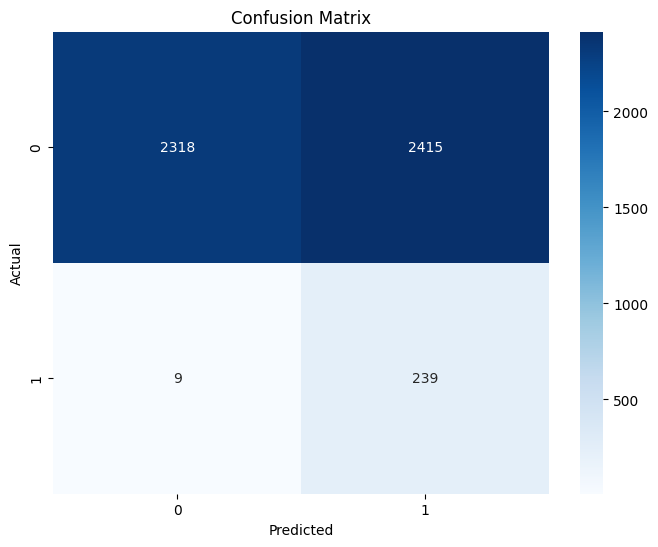

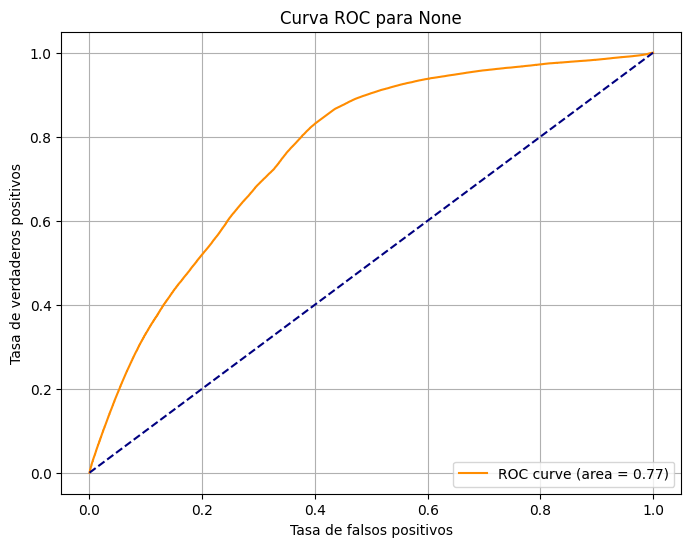

In [ ]:
# Llama a la función evaluate_models
evaluate_models(models, X, y)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=311bc360-0ff3-42ad-8fe8-990672a12326' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>